In [6]:
import theano
from theano import tensor as T
from theano.tensor.nnet import conv2d
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
from theano.tensor.signal import downsample
import numpy
import numpy as np
import time
import pylab
from PIL import Image
from Data import Load
import csv
import os
import pickle
import sys
from sklearn.utils import shuffle

from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
from theano.tensor.nnet.conv import conv2d
from theano.tensor.signal.downsample import max_pool_2d

################################################################################
# Global utilities and functions
################################################################################
srng = RandomStreams()

def floatX(X):
    return np.asarray(X, dtype=theano.config.floatX)

def dropout(X, p=0.):
    if p > 0:
        X *= srng.binomial(X.shape, p=1 - p, dtype=theano.config.floatX)
        X /= 1 - p
    return X

def backprop(cost, w, alpha=0.001, rho=0.9, epsilon=1e-6):
    grads = T.grad(cost=cost, wrt=w)
    updates = []
    for w1, grad in zip(w, grads):
        
        # adding gradient scaling
        acc = theano.shared(w1.get_value() * 0.)
        acc_new = rho * acc + (1 - rho) * grad ** 2
        gradient_scaling = T.sqrt(acc_new + epsilon)
        grad = grad / gradient_scaling
        updates.append((acc, acc_new))
        
        updates.append((w1, w1 - grad * alpha))
    return updates

################################################################################
## (1) Convolutional Network Parameters
################################################################################
numClasses = 30
numHiddenNodes = 1000 
patchWidth = 3
patchHeight = 3
featureMapsLayer1 = 32
featureMapsLayer2 = 64
featureMapsLayer3 = 128

# Regularization parameter for the fully connected NN
lambda_reg = .00000001

# For convonets, we will work in 2d rather than 1d.  The dataset images are 96 * 96
imageWidth = 96

# Convolution layers.  
w_1 = theano.shared(floatX(np.asarray((np.random.randn(*(featureMapsLayer1, 1, patchWidth, patchHeight))*.01))))
w_2 = theano.shared(floatX(np.asarray((np.random.randn(*(featureMapsLayer2, featureMapsLayer1, patchWidth, patchHeight))*.01))))
w_3 = theano.shared(floatX(np.asarray((np.random.randn(*(featureMapsLayer3, featureMapsLayer2, patchWidth, patchHeight))*.01))))

# Fully connected NN. 
w_4 = theano.shared(floatX(np.asarray((np.random.randn(*(featureMapsLayer3 * 10 * 10, numHiddenNodes))*.01))))
w_5 = theano.shared(floatX(np.asarray((np.random.randn(*(numHiddenNodes, numHiddenNodes))*.01))))
w_6 = theano.shared(floatX(np.asarray((np.random.randn(*(numHiddenNodes, numClasses))*.01))))

# Bias values
b_1 = theano.shared(value=numpy.zeros((featureMapsLayer1,), dtype=theano.config.floatX), borrow=True)
b_2 = theano.shared(value=numpy.zeros((featureMapsLayer2,), dtype=theano.config.floatX), borrow=True)
b_3 = theano.shared(value=numpy.zeros((featureMapsLayer3,), dtype=theano.config.floatX), borrow=True)

params = [w_1, w_2, w_3, w_4, w_5, w_6, b_1, b_2, b_3]

## (2) Model
X = T.matrix('X').reshape((-1, 1, 96, 96)) # conv2d works with tensor4 type
Y = T.matrix('Y')


# Theano provides built-in support for add convolutional layers
def convolutional_model(X, w_1, w_2, w_3, w_4, w_5, w_6, p_1, p_2, p_3, p_4, p_5):
    l1 = dropout(T.tanh( max_pool_2d(T.maximum(conv2d(X, w_1, border_mode='full'),0.), (2, 2),ignore_border=True) + b_1.dimshuffle('x', 0, 'x', 'x') ), p_1)
    l2 = dropout(T.tanh( max_pool_2d(T.maximum(conv2d(l1, w_2), 0.), (2, 2),ignore_border=True) + b_2.dimshuffle('x', 0, 'x', 'x') ), p_2)
    l3 = dropout(T.flatten(T.tanh( max_pool_2d(T.maximum(conv2d(l2, w_3), 0.), (2, 2),ignore_border=True) + b_3.dimshuffle('x', 0, 'x', 'x') ), outdim=2), p_3)# flatten to switch back to 1d layers
    l4 = dropout(T.maximum(T.dot(l3, w_4), 0.), p_4)
    l5 = dropout(T.maximum(T.dot(l4, w_5), 0.), p_5)
    return T.dot(l5, w_6)

y_hat_train = convolutional_model(X, w_1, w_2, w_3, w_4, w_5, w_6, 0.1, 0.2, 0.3, 0.5, 0.5)
y_hat_predict = convolutional_model(X, w_1, w_2, w_3, w_4, w_5, w_6, 0., 0., 0., 0., 0.)

## (3) Regularized Cost
cost = ((Y - (y_hat_predict))**2).mean() + lambda_reg*((w_4**2).sum() + (w_5**2).sum() + (w_6**2).sum())

## (4) Minimization.  
update = backprop(cost, params)
train = theano.function(inputs=[X, Y], outputs=cost, updates=update, allow_input_downcast=True)
y_pred = y_hat_predict
predict = theano.function(inputs=[X], outputs=y_pred, allow_input_downcast=True)

###############################################################################
# One Hidden layer NN to process convo prediction output
###############################################################################
back_num_inputs = 9
back_num_hidden = 30
back_num_outputs = 30
back_pdrop_input = .0
back_pdrop_hidden = .0

back_X = T.fmatrix("back_X")
back_Y = T.fmatrix("back_Y")

back_w_h = theano.shared(floatX(np.asarray((np.random.randn(*(back_num_inputs, back_num_hidden))*.01))))
back_w_o = theano.shared(floatX(np.asarray((np.random.randn(*(back_num_hidden, back_num_outputs))*.01))))

def back_model(back_X, back_w_h, back_w_o, p_drop_input, p_drop_hidden):
    X = dropout(back_X, p_drop_input)

    h = T.maximum(T.dot(back_X, back_w_h), 0.)
    h = dropout(h, back_pdrop_hidden)

    back_py_x = T.dot(h, back_w_o)
    return h, back_py_x


back_noise_h, back_noise_py_x = back_model(back_X, back_w_h, back_w_o, back_pdrop_input, back_pdrop_hidden)
back_h, back_py_x = back_model(back_X, back_w_h, back_w_o, 0., 0.)


back_cost = ((back_Y - back_noise_py_x)**2).mean()

back_params = [back_w_h, back_w_o]
back_updates = backprop(back_cost, back_params)

back_train = theano.function(inputs=[back_X, back_Y], outputs=back_cost, updates=back_updates, allow_input_downcast=True)
back_predict = theano.function(inputs=[back_X], outputs=back_py_x, allow_input_downcast=True)


################################################################################
# Model Execution
################################################################################

all_X, all_Y = Load.load()

test_indices = np.random.choice(all_X.shape[0], .2*all_X.shape[0], replace=False)
keep = np.ones(all_X.shape[0], dtype=bool) # array of True matching 1st dim
keep[test_indices] = False
trX = all_X[keep,:]
trY = all_Y[keep,:]
deX = all_X[test_indices]
deY = all_Y[test_indices]

rot_X, rot_Y = Load.rotate_images(trX, trY)
blur_X, blur_Y = Load.blurr_images(trX, trY)
trans_X, trans_Y = Load.transpose_images(trX, trY)

trX, trY = np.vstack((trX, rot_X)), np.vstack((trY, rot_Y))
trX, trY = np.vstack((trX, blur_X)), np.vstack((trY, blur_Y))
trX, trY = np.vstack((trX, trans_X)), np.vstack((trY, trans_Y))

trX, trY = shuffle(trX, trY, random_state=42)  # shuffle data
rot_X, rot_Y, blur_X, blur_Y, tr_X, tr_Y = None, None, None, None, None, None

trX = trX.reshape(-1, 1, imageWidth, imageWidth)
deX = deX.reshape(-1, 1, imageWidth, imageWidth)

miniBatchSize = 1
def convolutional_gradientDescentStochastic(epochs):
    training_costs=[]
    dev_costs=[]
    trainTime = 0.0
    predictTime = 0.0
    start_time = time.time()
    for i in range(epochs):       
        for start, end in zip(range(0, len(trX), miniBatchSize), range(miniBatchSize, len(trX), miniBatchSize)):
            cost = train(trX[start:end], trY[start:end])
        
        # Compute overall dev and training costs after epoch
        pdeY = predict(deX)
        cost_de = ((deY - pdeY)**2).mean()
        
        ptrY = predict(trX)
        cost_tr = ((trY - ptrY)**2).mean()
        
        # Capture the traning and dev costs on each epoch
        training_costs.append(cost_tr)
        dev_costs.append(cost_de)
        
        print '%d) Convo precision=%.8f, Traning cost=%.8f, DE cost: %.8f' %(i+1, np.mean(np.allclose(deY, pdeY)), cost_tr, cost_de)
        trainTime =  trainTime + (time.time() - start_time)
    print 'train time = %.2f' %(trainTime)
    
    return training_costs, dev_costs, ((trY - ptrY)**2), ((deY - pdeY)**2)

convo_training_costs, convo_dev_costs,  convo_training_costs_raw, convo_dev_costs_raw = convolutional_gradientDescentStochastic(1)


back_miniBatchSize = 1
def back_gradientDescentStochastic(epochs):
    training_costs=[]
    dev_costs=[]
    trainTime = 0.0
    predictTime = 0.0
    start_time = time.time()
    for i in range(epochs):       
        for start, end in zip(range(0, len(convo_training_costs_raw), miniBatchSize), range(miniBatchSize, len(convo_training_costs_raw), miniBatchSize)):
            cost = back_train(convo_training_costs_raw[start:end], trY[start:end])

        # Compute overall dev and training costs after epoch
        pdeY = back_predict(convo_dev_costs_raw)
        cost_de = ((deY - pdeY)**2).mean()

        ptrY = back_predict(trX)
        cost_tr = ((trY - ptrY)**2).mean()

        # Capture the traning and dev costs on each epoch
        training_costs.append(cost_tr)
        dev_costs.append(cost_de)

        print '%d) Back precision=%.4f, Traning cost=%.4f, DE cost: %.4f' %(i+1, np.mean(np.allclose(deY, pdeY)), cost_tr, cost_de)
        trainTime =  trainTime + (time.time() - start_time)
    print 'train time = %.2f' %(trainTime)

    return training_costs, dev_costs

back_training_costs, back_dev_costs = back_gradientDescentStochastic(1)


print 'Mean squared error on Training data: %.8f\n'%((trY - trY.mean())**2).mean()
print 'Mean squared error on Dev data: %.8f\n'%((deY - deY.mean())**2).mean()

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:122: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


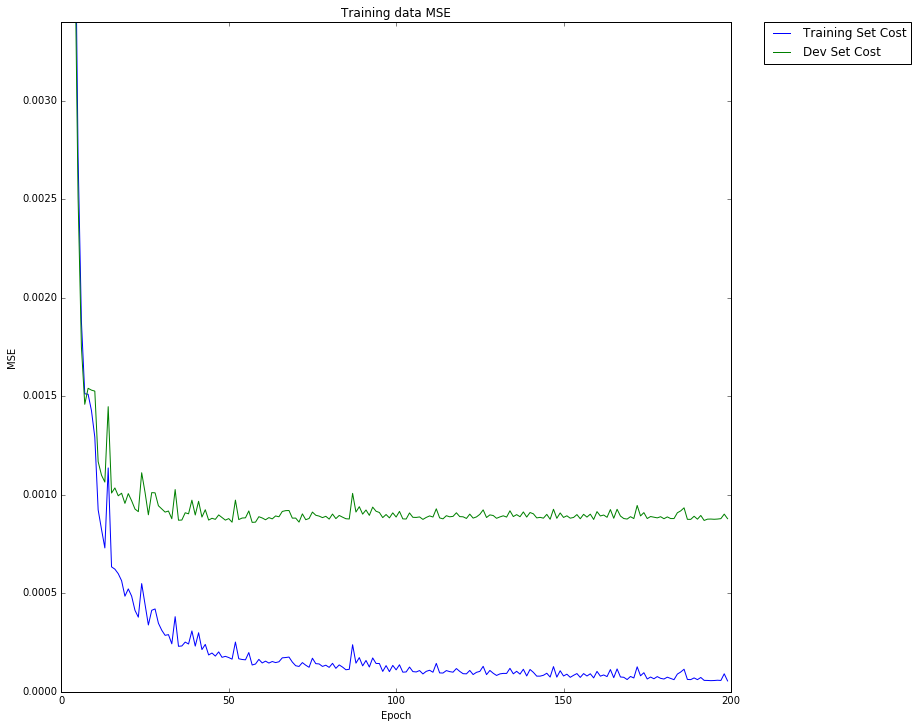

In [19]:
%matplotlib inline
import matplotlib.colors as clrs
import matplotlib.pyplot as plt

# Plot the trainig data costs over time
plt.figure(figsize=(12, 12))
training_plt = plt.plot(training_costs, c='b', label='Training Set Cost')
dev_plt = plt.plot(dev_costs, c='g', label='Dev Set Cost')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Training data MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.axis([0, 200, 0, 0.0034])
plt.show()

In [8]:
def plot_sample(axis, x, y, y_pred=None,):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', c='r', s=10)
    
    if y_pred is not None:
        axis.scatter(y[0::2] * 48 + 48, y_pred[1::2] * 48 + 48, marker='x', s=10)

[229  25  43 299 142 167 160 203 401 108 352 101  70  60  71 393 340 152
  22  63]
[ 0.0224315   0.01431197  0.00909775  0.00709994  0.00616949  0.00489442
  0.00450183  0.00449614  0.0040058   0.00370122  0.00352611  0.00349892
  0.00332948  0.00324372  0.00316477  0.00312852  0.00310209  0.00308087
  0.00288074  0.00287216]


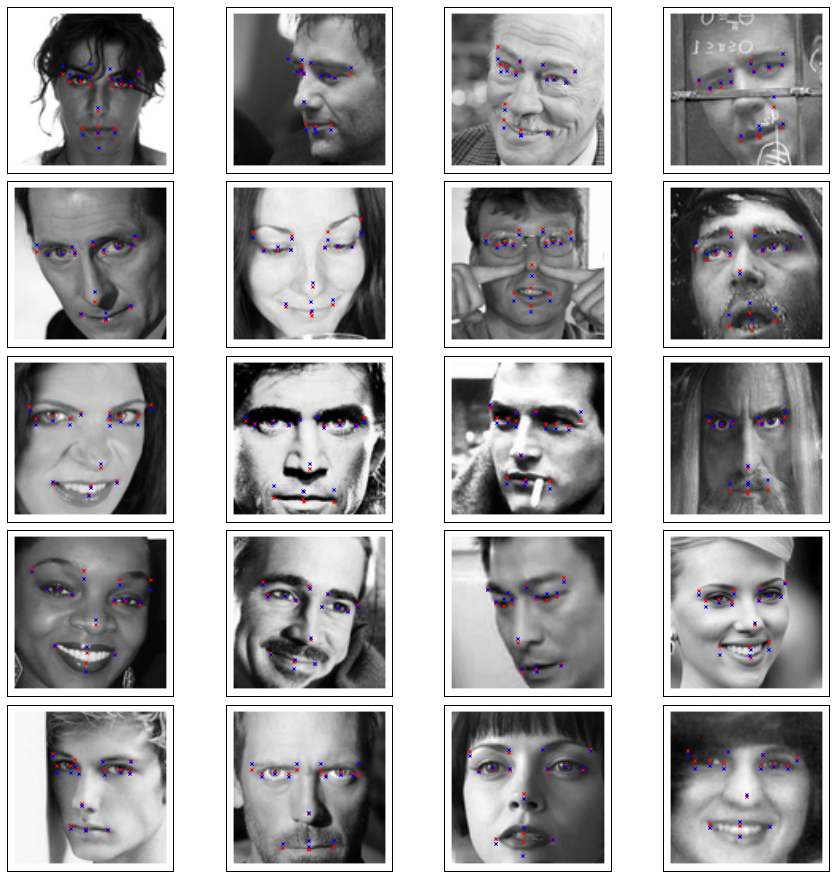

In [9]:
# Find the dev set images with the highest costs
final_pdeY = predict(deX)
final_cost_de = ((deY - final_pdeY)**2).mean(axis=1)
final_ptrY = predict(trX)
final_cost_tr = ((trY - final_ptrY)**2).mean(axis=1)

# Print the highest dev set indices
highest_dev_indices = np.array(final_cost_de).argsort()[::-1][:20]
print highest_dev_indices

# Print the highest dev costs
highest_dev_costs = final_cost_de.copy()
highest_dev_costs.sort()
print highest_dev_costs[::-1][:20]

# Plot the images with the highest dev costs
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(0,20):
    ax = fig.add_subplot(5, 4, i + 1, xticks=[], yticks=[])
    plot_sample(ax, deX[highest_dev_indices[i]], deY[highest_dev_indices[i]], final_pdeY[highest_dev_indices[i]])

[2566 1320 1526  923 1547 1975 2167  874 1011 1274 2117 2266  985  374 1562
 1314 1369  851 1156 1640]
[ 0.00029704  0.00019874  0.00016949  0.00016914  0.00016073  0.0001548
  0.00015235  0.00015135  0.00014598  0.00014401  0.00014388  0.00014254
  0.00013994  0.00013934  0.00013866  0.00013832  0.00013731  0.00013715
  0.00013681  0.00013527]


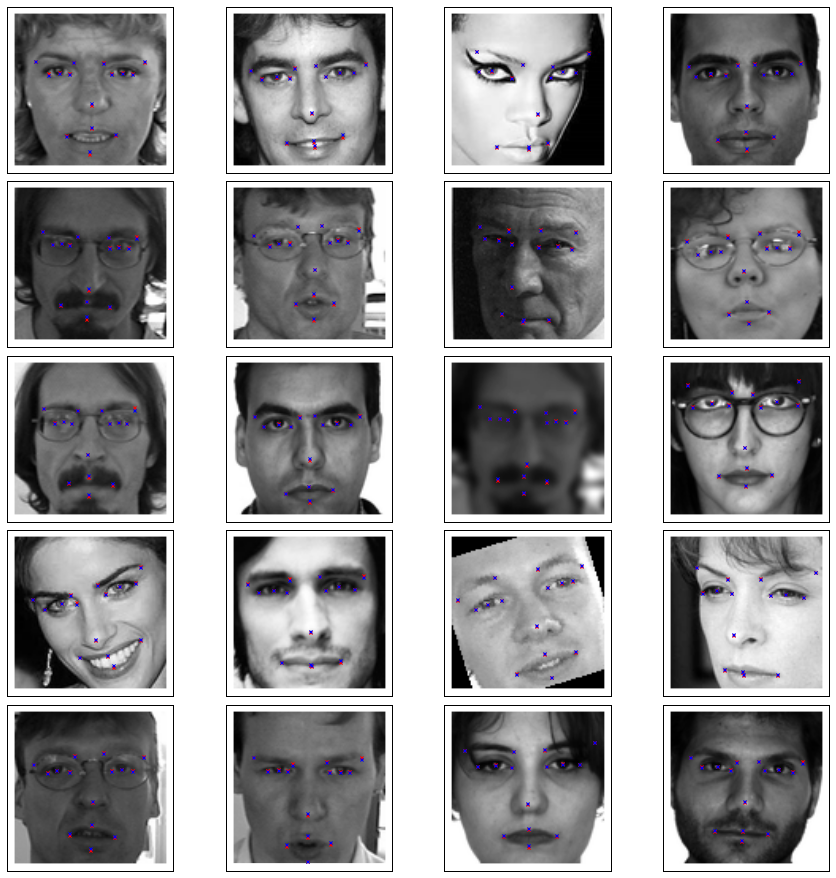

In [10]:
# Print the highest training set indices
highest_tr_indices = np.array(final_cost_tr).argsort()[::-1][:20]
print highest_tr_indices

# Print the highest training costs
highest_tr_costs = final_cost_tr.copy()
highest_tr_costs.sort()
print highest_tr_costs[::-1][:20]

# Plot the images with the highest training costs
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(0,20):
    ax = fig.add_subplot(5, 4, i + 1, xticks=[], yticks=[])
    plot_sample(ax, trX[highest_tr_indices[i]], trY[highest_tr_indices[i]], final_ptrY[highest_tr_indices[i]])

('Quartiles: ', array([  7.40760806e-05,   2.87863128e-04,   4.59289600e-04,
         8.64707952e-04]))


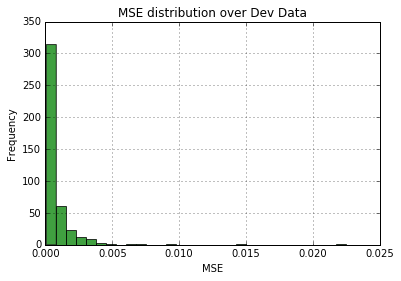

('Quartiles: ', array([  1.50298911e-06,   3.73521598e-05,   5.11016733e-05,
         6.75357987e-05]))


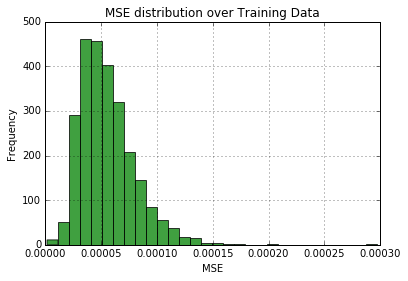

In [11]:
# Let's look into the distribution of the costs on the dev data
print('Quartiles: ', np.percentile(final_cost_de, np.arange(0, 100, 25))) # quartiles
n, bins, patches = plt.hist(final_cost_de, bins=30, facecolor='green', alpha=0.75)

plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.title('MSE distribution over Dev Data')
#plt.axis([40, 160, 0, 0.03])
plt.grid(True)

plt.show()

# Let's look at the Training Data ditribution
print('Quartiles: ', np.percentile(final_cost_tr, np.arange(0, 100, 25))) # quartiles
n, bins, patches = plt.hist(final_cost_tr, bins=30, facecolor='green', alpha=0.75)

plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.title('MSE distribution over Training Data')
#plt.axis([40, 160, 0, 0.03])
plt.grid(True)

plt.show()

(30,)
[ 0.0004432   0.00027607  0.00069957  0.00033487  0.00041283  0.00036274
  0.00077666  0.00038777  0.00066577  0.0003478   0.00109951  0.00041596
  0.00095717  0.00074071  0.00095136  0.00147359  0.00115933  0.00087022
  0.00150408  0.0013442   0.00124064  0.00098424  0.00122773  0.00095395
  0.00144556  0.00089576  0.00072448  0.0010979   0.00078324  0.00179219]


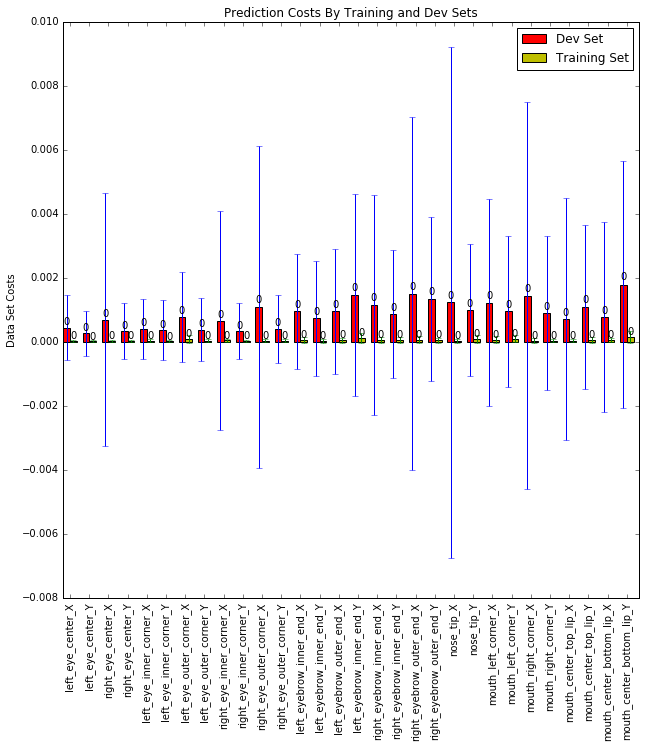

In [12]:
# Which features are we learning best and which are we learning poorly?
# build a bar chart of the dev and training errors per feature.
feature_names = ['left_eye_center_X', 'left_eye_center_Y', 'right_eye_center_X', 'right_eye_center_Y', 
                'left_eye_inner_corner_X', 'left_eye_inner_corner_Y',
                'left_eye_outer_corner_X', 'left_eye_outer_corner_Y',  
                'right_eye_inner_corner_X', 'right_eye_inner_corner_Y',
                'right_eye_outer_corner_X', 'right_eye_outer_corner_Y', 
                'left_eyebrow_inner_end_X', 'left_eyebrow_inner_end_Y',
                'left_eyebrow_outer_end_X', 'left_eyebrow_inner_end_Y', 
                'right_eyebrow_inner_end_X', 'right_eyebrow_inner_end_Y', 
                'right_eyebrow_outer_end_X', 'right_eyebrow_outer_end_Y',
                'nose_tip_X', 'nose_tip_Y', 'mouth_left_corner_X', 'mouth_left_corner_Y',
                'mouth_right_corner_X', 'mouth_right_corner_Y',
                'mouth_center_top_lip_X', 'mouth_center_top_lip_Y',
                'mouth_center_bottom_lip_X', 'mouth_center_bottom_lip_Y']

feature_costs_de_means = ((deY - final_pdeY)**2).mean(axis=0)
print feature_costs_de_means.shape
print feature_costs_de_means
feature_costs_de_std = ((deY - final_pdeY)**2).std(axis=0)
feature_costs_tr_means = ((trY - final_ptrY)**2).mean(axis=0)
feature_costs_tr_std = ((trY - final_ptrY)**2).std(axis=0)

# the x locations for the groups
ind = np.arange(feature_costs_de_means.shape[0])
# the width of the bars
width = 0.35       

fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

#fig, ax = fig.subplots()
ax = plt.subplot()
rects1 = ax.bar(ind, feature_costs_de_means, width, color='r', yerr=feature_costs_de_std)
ax = plt.subplot()
rects2 = ax.bar(ind + width, feature_costs_tr_means, width, color='y', yerr=feature_costs_tr_std)

# add some text for labels, title and axes ticks
ax.set_ylabel('Data Set Costs')
ax.set_title('Prediction Costs By Training and Dev Sets')
ax.set_xticks(ind + width)
ax.set_xticklabels(feature_names, rotation=90)

ax.legend((rects1[0], rects2[0]), ('Dev Set', 'Training Set'))

def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

In [14]:
# 
# Let's build functions to look into the convolution filters of all layers
#

# instantiate 4D tensor for input
input = T.tensor4(name='input')

output_1 = T.tanh( max_pool_2d(T.maximum(conv2d(input, w_1, border_mode='full'),0.), (2, 2),ignore_border=True) + b_1.dimshuffle('x', 0, 'x', 'x') )

output_2 = T.tanh( max_pool_2d(T.maximum(conv2d(output_1, w_2), 0.), (2, 2),ignore_border=True) + b_2.dimshuffle('x', 0, 'x', 'x') )

output_3 = T.tanh( max_pool_2d(T.maximum(conv2d(output_2, w_3), 0.), (2, 2),ignore_border=True) + b_3.dimshuffle('x', 0, 'x', 'x') )

# create theano function to compute filtered images
my_f1 = theano.function(inputs=[input], outputs=output_1, allow_input_downcast=True)
my_f2 = theano.function(inputs=[input], outputs=output_2, allow_input_downcast=True)
my_f3 = theano.function(inputs=[input], outputs=output_3, allow_input_downcast=True)


In [15]:
# Prepare an image
img_ = trX[highest_tr_indices[0]].reshape(-1, 1, 96, 96)
print 'Image shape: ', img_.shape

Image shape:  (1, 1, 96, 96)


('filtered image shape: ', (1, 32, 49, 49))


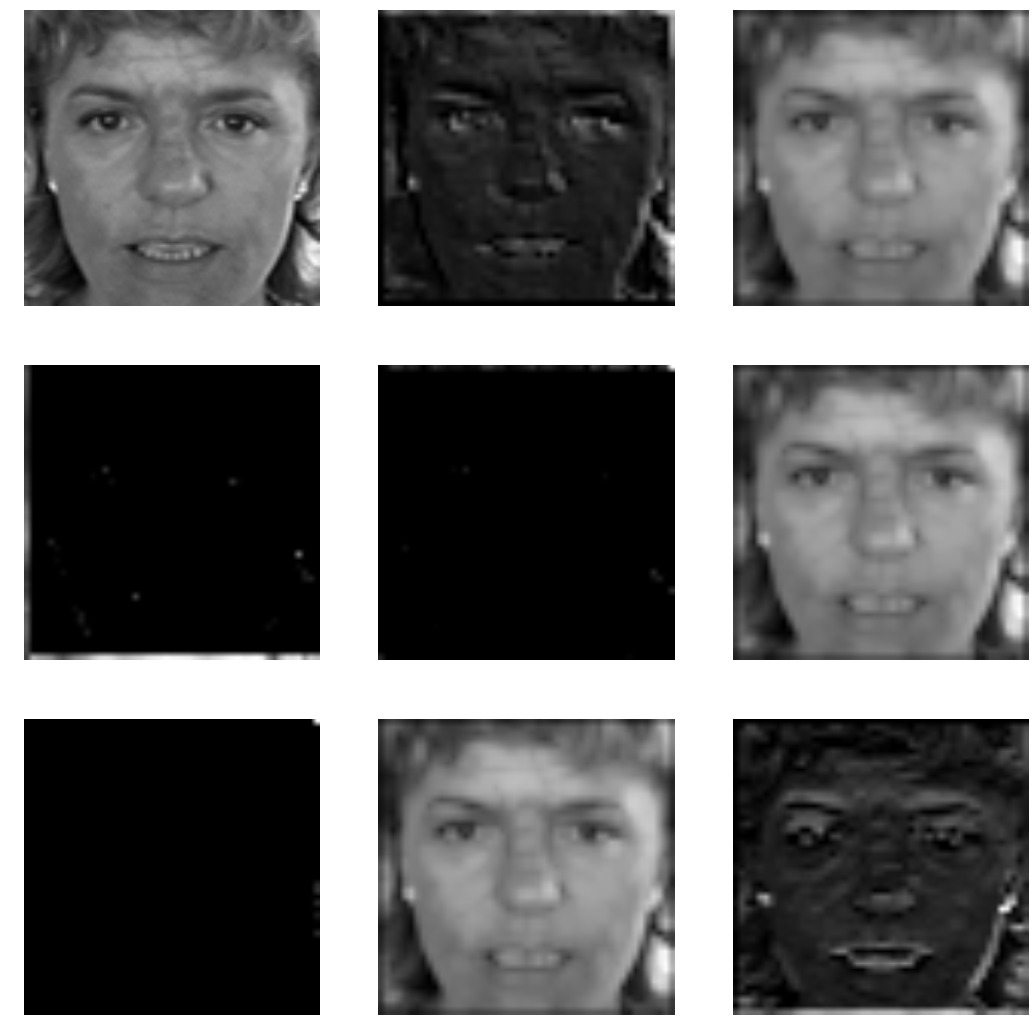

In [16]:
# Layer 1 output
filtered_img = my_f1(img_)
print("filtered image shape: ", filtered_img.shape)

pylab.figure(figsize=(18, 18))
# plot original image and first and second components of output
pylab.subplot(3, 3, 1); pylab.axis('off'); pylab.imshow(img_[0,0,:,:])
pylab.gray();

for i in range(0,8):
    pylab.subplot(3, 3, i+2); pylab.axis('off'); pylab.imshow(filtered_img[0, i, :, :])
pylab.show()

('filtered image shape: ', (1, 64, 23, 23))


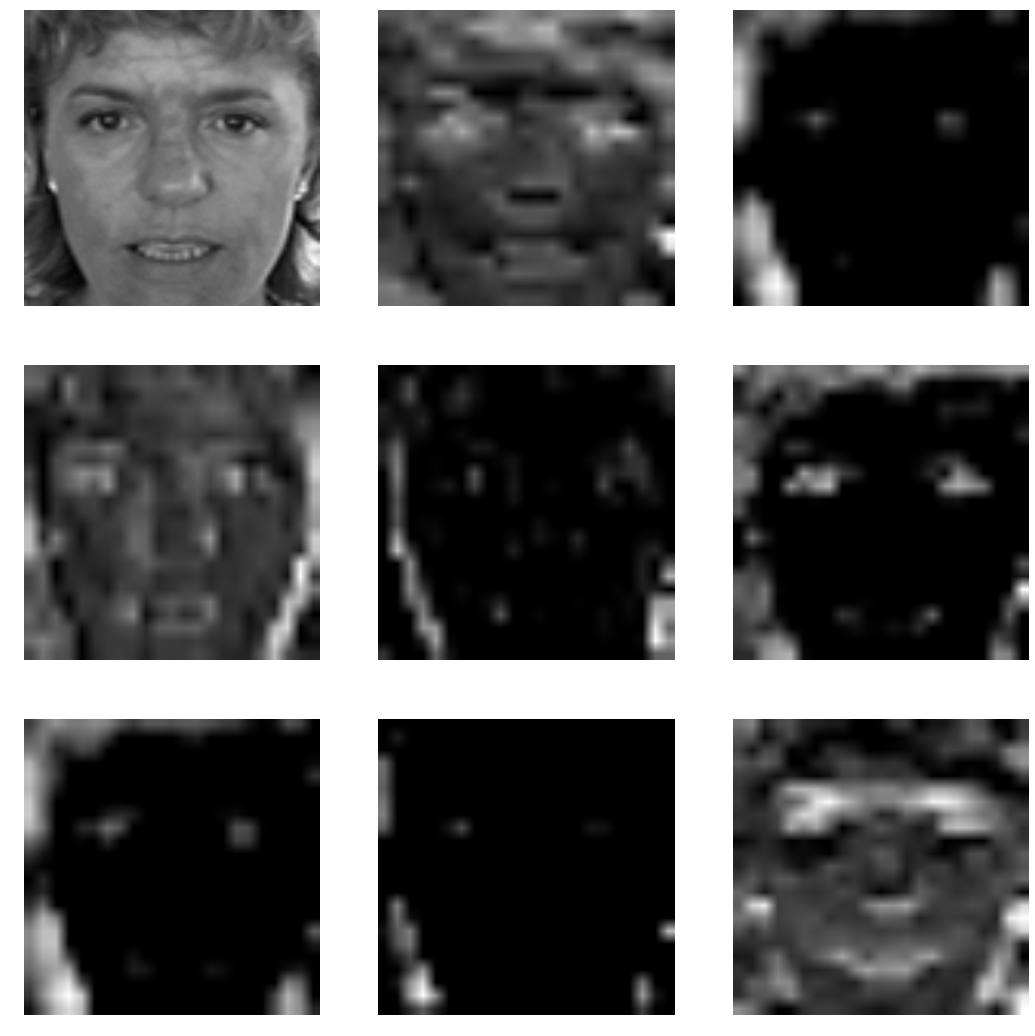

In [17]:
# Layer 2 output
filtered_img = my_f2(img_)
print("filtered image shape: ", filtered_img.shape)

pylab.figure(figsize=(18, 18))
# plot original image and first and second components of output
pylab.subplot(3, 3, 1); pylab.axis('off'); pylab.imshow(img_[0,0,:,:])
pylab.gray();

for i in range(0,8):
    pylab.subplot(3, 3, i+2); pylab.axis('off'); pylab.imshow(filtered_img[0, i, :, :])
pylab.show()

('filtered image shape: ', (1, 128, 10, 10))


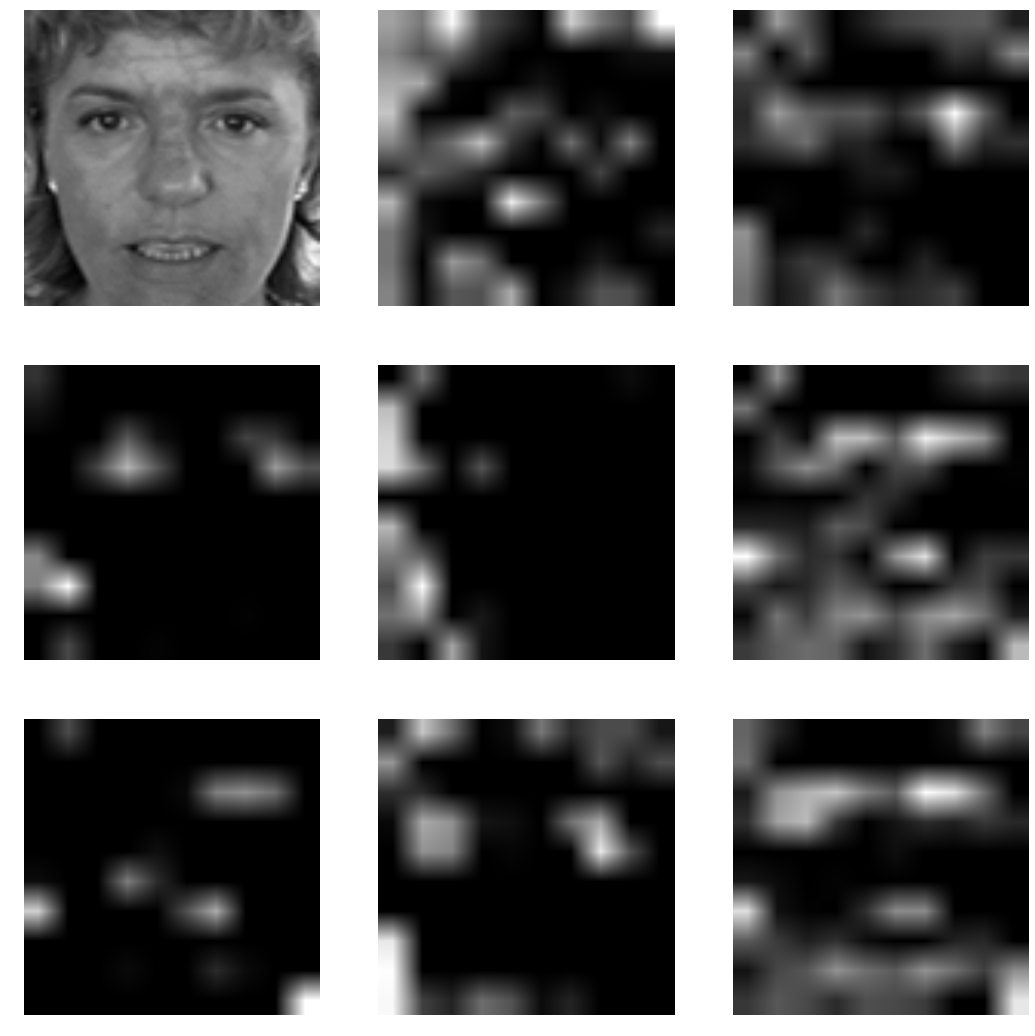

In [18]:
# Layer 3 output
filtered_img = my_f3(img_)
print("filtered image shape: ", filtered_img.shape)

pylab.figure(figsize=(18, 18))
# plot original image and first and second components of output
pylab.subplot(3, 3, 1); pylab.axis('off'); pylab.imshow(img_[0,0,:,:])
pylab.gray();

for i in range(0,8):
    pylab.subplot(3, 3, i+2); pylab.axis('off'); pylab.imshow(filtered_img[0, i, :, :])
pylab.show()